In [1]:
# Install conda
!pip install -q condacolab
import condacolab
condacolab.install()
# Install astra-toolbox
!conda install -c astra-toolbox astra-toolbox

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...
Channels:
 - astra-toolbox
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    astra-toolbox-2.3.1        |  py311h14163b8_0         453 KB  astra-toolbox
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    cuda-cudart-12.8.90        |       h5888daf_1          22 KB  conda-forge
    cuda-cudart_linux-6

In [1]:
!pip install odl[testing,show]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 28.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7fe2251614741313a7f21864dbe4dec6cd2de07af4a09181d1cb76eb587b1cf4
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


In [2]:
import odl
import astra
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import numpy as np
astra.test()

ASTRA Toolbox v2.3.1
Getting GPU info... GPU #0: Tesla T4, with 15095MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import zipfile
import matplotlib.pyplot as plt

In [4]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [49]:
img_size, space_range = 512, 512 #space discretization
num_angles, det_shape = 100, 200 #projection parameters
noise_std_dev = 5.0

space = odl.uniform_discr([-space_range, -space_range], [space_range, space_range],(img_size,img_size), dtype='float32', weighting=1.0)
geometry = odl.tomo.geometry.parallel.parallel_beam_geometry(space, num_angles=num_angles, det_shape=det_shape)
fwd_op_odl = odl.tomo.RayTransform(space, geometry,impl='astra_cuda')
opnorm  =1
#opnorm = odl.power_method_opnorm(fwd_op_odl)
rt = (1 / opnorm) * fwd_op_odl
fbp_op_odl = odl.tomo.fbp_op(fwd_op_odl,filter_type='Ram-Lak', frequency_scaling=0.6)

import odl.contrib.torch as odl_torch
A = odl_torch.OperatorModule(rt).to(device)
adjA = odl_torch.OperatorModule(rt.adjoint).to(device)
fbp = odl_torch.OperatorModule(fbp_op_odl).to(device)

In [6]:
import os
import zipfile
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset directories
train_dir = "/kaggle/input/liv-seg/train"
val_dir = "/kaggle/input/liv-seg/val"
test_dir = "/kaggle/input/liv-seg/test"

In [7]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset


class LiverSegDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            label_dir (str): Directory with all the labels.
            transform (callable, optional): Transform to be applied to images.
            target_transform (callable, optional): Transform to be applied to labels.
        """
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith(('.png', '.jpg', '.jpeg', '.npy'))  # Filter for valid formats
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, fname)
            for fname in os.listdir(label_dir)
            if fname.endswith(('.png', '.jpg', '.jpeg', '.npy'))  # Filter for valid formats
        ])
        self.transform = transform
        self.target_transform = target_transform

        # self.resize = transforms.Resize((128, 128), antialias=True)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Handle images and labels depending on their file type
        if img_path.endswith('.npy'):
            image = np.load(img_path).astype(np.float32)
            image = image - image.min()
        else:
            image = np.array(Image.open(img_path)).astype(np.float32)

        if label_path.endswith('.npy'):
            label = np.load(label_path).astype(np.float32)
        else:
            label = np.array(Image.open(label_path)).astype(np.float32)

        # Rotate both image and label 90 degrees counterclockwise
        image = np.rot90(image, k=1).copy()  # Rotate and copy to ensure positive strides
        label = np.rot90(label, k=1).copy()  # Rotate and copy to ensure positive strides

        # Convert to PIL for resizing
        image = Image.fromarray(image)
        label = Image.fromarray(label)

        # image = self.resize(image)
        # label = self.resize(label)

        # Ensure images and labels are in tensor format
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image).float()

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = transforms.ToTensor()(label).float()

        image = 255* (image - image.min()) / (image.max() - image.min() + 1e-8)
        return image, label

In [50]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
# Define transformations
image_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

label_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())  # Convert PIL Image to NumPy array first
])

# Create datasets with transforms
train_dataset = LiverSegDataset(
    image_dir=os.path.join(train_dir, 'images'),
    label_dir=os.path.join(train_dir, 'labels'),
    transform=image_transforms,
    target_transform=label_transforms
)

val_dataset = LiverSegDataset(
    image_dir=os.path.join(val_dir, 'images'),
    label_dir=os.path.join(val_dir, 'labels'),
    transform=image_transforms,
    target_transform=label_transforms
)

test_dataset = LiverSegDataset(
    image_dir=os.path.join(test_dir, 'images'),
    label_dir=os.path.join(test_dir, 'labels'),
    transform=image_transforms,
    target_transform=label_transforms
)

# Create DataLoaders
batch_size = 1

num_train_samples = 30  # example: use only 100 training samples
num_val_samples = 30
num_test_samples = len(test_dataset)

# Create index subsets
train_indices = np.random.choice(len(train_dataset), num_train_samples, replace=False)
val_indices = np.random.choice(len(val_dataset), num_val_samples, replace=False)
test_indices = np.random.choice(len(test_dataset), num_test_samples, replace=False)

# Wrap original datasets with Subset
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

print("DataLoaders created:")
print(f"Train size: {len(train_loader)} batches")
print(f"Validation size: {len(val_loader)} batches")
print(f"Test size: {len(test_loader)} batches")

DataLoaders created:
Train size: 30 batches
Validation size: 30 batches
Test size: 262 batches


IndexError: index 1 is out of bounds for dimension 0 with size 1

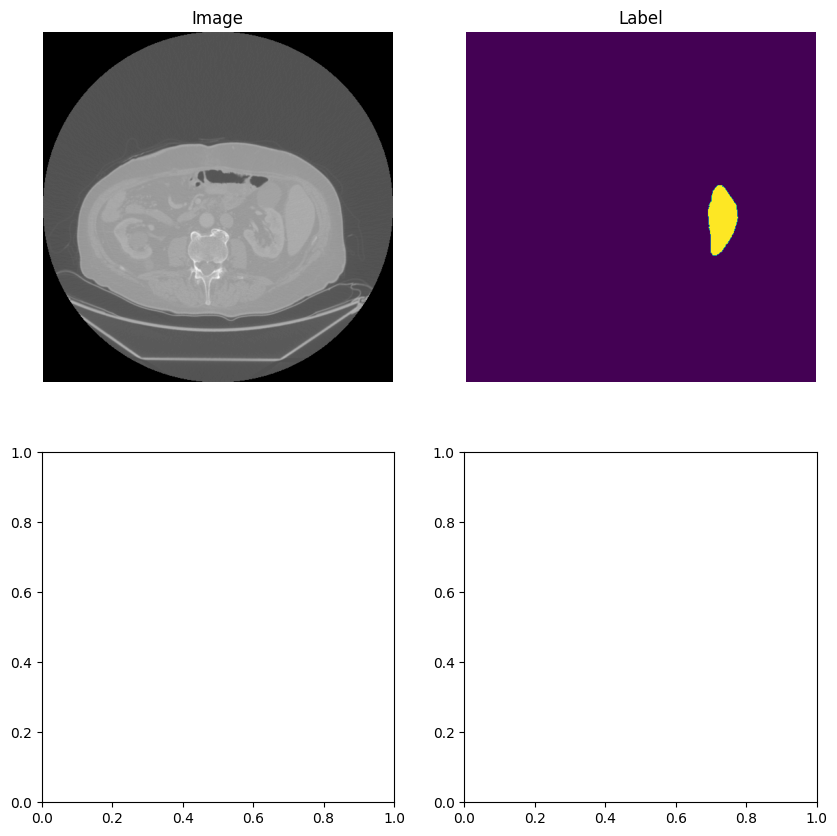

In [10]:
# Plot some images
def plot_samples(data_loader, num_samples=2):
    images, labels = next(iter(data_loader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        lbl = labels[i].squeeze().numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(lbl, cmap='viridis')  # Display labels with color mapping
        axes[i, 1].set_title("Label")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_samples(train_loader)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a double convolution block: two conv layers with BatchNorm and ReLU.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the down-sampling block: max-pooling followed by a double conv.
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Define the up-sampling block: upsample (or transpose conv) followed by concatenation and a double conv.
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        # if bilinear, use the normal upsampling method; otherwise, use transposed convolution.
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # in_channels is doubled since we'll concatenate features from the encoder.
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is from the previous layer, x2 is the corresponding feature map from the encoder.
        x1 = self.up(x1)
        # Adjust padding if necessary (in case the sizes don't match exactly).
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate along the channels dimension.
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Define the final output convolution.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Now define the complete U-Net architecture.
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, bilinear=True):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)      # Encoder stage 1
        x2 = self.down1(x1)   # Encoder stage 2
        x3 = self.down2(x2)   # Encoder stage 3
        x4 = self.down3(x3)   # Encoder stage 4
        x5 = self.down4(x4)   # Bottleneck
        x = self.up1(x5, x4)  # Decoder stage 1 with skip connection from x4
        x = self.up2(x, x3)   # Decoder stage 2 with skip connection from x3
        x = self.up3(x, x2)   # Decoder stage 3 with skip connection from x2
        x = self.up4(x, x1)   # Decoder stage 4 with skip connection from x1
        logits = self.outc(x)
        return logits

segmentation_net = UNet(in_channels=1, out_channels=3).to(device)

In [52]:
import torch.optim as optim
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  # Compute probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion_seg = FocalLoss(alpha=0.25, gamma=2)

In [53]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
from torch import Tensor
def dice_coeff(inp : Tensor, tgt : Tensor, eps=1e-6):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

def log_cosh_dice_loss(input: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    # Compute the Dice coefficient
    dice = dice_coeff(input, target)
    
    # Compute Dice loss
    dice_loss_value = 1 - dice
    
    # Apply Log-Cosh to the Dice loss
    return torch.log(torch.cosh(dice_loss_value + eps))

In [54]:
def conjugate_gradient(H, b, tol=1e-6, max_iter=100): #used to solve Hx = b, where H is function 
                                                      #that calculates Hx.
    x = torch.zeros_like(b)
    r = b.clone()
    p = r.clone()
    rsold = torch.sum(r*r)

    for i in range(max_iter):
        Hp = H(p)
        alpha = rsold / torch.sum(p* Hp)
        x = x + alpha * p
        r = r - alpha * Hp
        rsnew = torch.sum(r*r)

        if torch.sqrt(rsnew) < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

# Smoothed Total Variation Function
def Smoothed_TV(x, theta):
    batch_size = x.size(0)
    diff_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    diff_x = F.pad(diff_x, (0, 1), mode='constant', value=0)
    diff_y = x[:, :, 1:, :] - x[:, :, :-1, :]
    diff_y = F.pad(diff_y, (0, 0, 0, 1), mode='constant', value=0)
    norm_grad = torch.sqrt(diff_x.pow(2) + diff_y.pow(2) + torch.exp(theta[1])**2)
    regularizer = torch.exp(theta[0]) * norm_grad.view(batch_size, -1).mean()
    return regularizer


In [55]:
import torch
import torch.nn.functional as F

def smoothed_norm(x, v):
    return torch.sum(torch.sqrt(x**2 + v**2))

def foe_regularizer(x, theta, kernel_size, num_kernels):
    K = num_kernels
    in_channels = x.size(1)  # Number of input channels (e.g., 3 for RGB)

    # Extract the overall scaling term exp(θ[0])
    exp_theta_0 = torch.exp(theta[0])

    regularizer = 0.0  # Initialize the regularizer
    for k in range(K):
        # Extract the individual kernel for the current filter
        start_idx = 2*K + k * in_channels * kernel_size * kernel_size
        end_idx = start_idx + in_channels * kernel_size * kernel_size
        kernel = theta[start_idx:end_idx].view(in_channels, 1, kernel_size, kernel_size)  # Shape (in_channels, 1, kernel_size, kernel_size)
        
#         print(f"start={start_idx},end:{end_idx},scaling:{k},norm:{K+k}")
        # Perform convolution with single kernel, apply padding
        padding = kernel_size // 2
        conv_x = F.conv2d(x, kernel, padding=padding, groups=in_channels)  # Use groups to apply across channels
#         print(conv_x.shape)
        # Apply smoothed norm
        norm_conv_x = smoothed_norm(conv_x, theta[K + k])  # The scaling term for the k-th kernel

        # Apply individual scaling term exp(θ[K + k + 1])
        exp_theta_k = torch.exp(torch.clamp(theta[k], max=10))  # Avoid overflow

        # Accumulate the regularizer
        regularizer += exp_theta_k * norm_conv_x

    # Apply overall scaling term
    regularizer *= exp_theta_0

    return regularizer

In [56]:
class RegularizerScaler(torch.nn.Module):
    def __init__(self, regu, initial_alpha=10**-5, kernel_size=7, num_kernels=10):
        super(RegularizerScaler, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(initial_alpha))
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.regu = regu

    def forward(self, noisy_x, lambda0):
        if self.regu == "smoothed_tv":
            regularizer = Smoothed_TV(noisy_x, lambda0)
        elif self.regu == "FoE":
            regularizer = (10**(-5))*foe_regularizer(noisy_x, lambda0, kernel_size=self.kernel_size, num_kernels=self.num_kernels)
        return regularizer

In [57]:
def inner_loss(noisy_x, x_star, lambda0, regularizer):
    residual = noisy_x - x_star
    loss = torch.mean(residual**2)
    regularizer_term = regularizer.forward(noisy_x, lambda0)
    return loss + regularizer_term

def inner_optimization(noisy_x, lambda0, x_star,regularizer,tol=1e-1, max_iter=100):
    recons_x = noisy_x.requires_grad_(True)
    
    # Include the parameters of the regularizer (i.e., alpha) in the optimizer
    optimizer = optim.LBFGS([recons_x] + list(regularizer.parameters()), lr=1e-1, max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)

    def closure():
        optimizer.zero_grad()
        loss = inner_loss(noisy_x, x_star,lambda0,regularizer=regularizer).to(noisy_x.device)
        loss.backward(retain_graph= True)
        return loss

    for _ in range(max_iter):
        optimizer.step(closure)

    return recons_x

In [58]:
def compute_Hv(loss, p, u, v, flag="both"): 
    """
    Compute the Hessian-vector product and the gradient.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - p: The vector to multiply with the Hessian.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    - flag: Specifies what to return ("grad", "both", "hess").
    
    Returns:
    - Depending on the flag, returns:
      - "grad": Gradient of the loss with respect to u.
      - "both": Gradient of the loss with respect to u and the Hessian-vector product.
      - "hess": Hessian-vector product only.
    """
    grad_u = autograd.grad(loss, u, create_graph=True)[0]
    
    if flag == "grad":
        return grad_u
    
    elif flag == "both":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return grad_u, Hv
    
    elif flag == "hess":
        dell_u_times_p = torch.sum(grad_u * p)
        Hv = autograd.grad(dell_u_times_p, v, retain_graph=True)[0]
        return Hv

def create_H_function(loss, u, v):
    """
    Creates a function H(p) that computes the Hessian-vector product for a given vector p.
    
    Parameters:
    - loss: Precomputed scalar loss.
    - u: Tensor with respect to which the first derivative is taken.
    - v: Tensor with respect to which the Hessian is calculated.
    
    Returns:
    - A function H(p) that computes the Hessian-vector product Hv.
    """
    def H(p):
        return compute_Hv(loss, p, u, v, flag="hess")
    
    return H

In [59]:
def outer_loss_fn(preds, labels, num_classes, **kwargs):
    focal_loss = FocalLoss(alpha=0.25, gamma=2)
    return focal_loss(preds, labels)

In [60]:
def hoag_algorithm(noisy_x, lambda0, x_star, labels, regu, 
                   T_star, device, outer_loss_fn, max_iter=20, k=1.0, 
                   epsilon=1e-6, kernel_size=5, num_kernels=2):
    
    lambda0 = lambda0.to(device)
    tol = 0.0001  # Initial tolerance

    # Initialize RegularizerScaler
    regularizer = RegularizerScaler(regu=regu, kernel_size=kernel_size, num_kernels=num_kernels).to(device)

    # Step (i): Solve the inner optimization problem to get the initial gradient
    recons_x = inner_optimization(noisy_x, lambda0, x_star, regularizer=regularizer, tol=tol).to(device)
    
    # Compute outer loss using the passed outer_loss_fn function
    output = T_star(recons_x)
    outer_loss = outer_loss_fn(output, labels,3).to(device)
    grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)
    
    # Compute the initial p1 (approximate gradient) and initialize L
    p1 = torch.linalg.matrix_norm(grad_g_x).mean().item()
    L = k * p1

    for iteration in range(max_iter):
        tol = max(tol * (1 - iteration / max_iter)**4, epsilon)  # Ensure tol does not go below epsilon

        # Step (i): Solve the inner optimization problem
        recons_x = inner_optimization(noisy_x, lambda0, x_star, regularizer=regularizer, tol=tol).to(device)
        
        # Compute outer loss using the passed outer_loss_fn function
        output = T_star(recons_x)
        outer_loss = outer_loss_fn(output, labels,3).to(device)
        
        # Compute the gradient with respect to recons_x
        grad_g_x = autograd.grad(outer_loss, recons_x, create_graph=True)[0].to(device)        
        
        # Step (ii): Compute the Hessian-vector product
        new_inner_loss = inner_loss(noisy_x, x_star, lambda0, regularizer).to(device)
        Hxx = create_H_function(new_inner_loss, recons_x, recons_x)
        q_k = conjugate_gradient(Hxx, grad_g_x, tol=tol, max_iter=max_iter)
        hxlambda = compute_Hv(new_inner_loss, q_k, recons_x, lambda0, flag="hess").to(device)
        p_k = -hxlambda
        noisy_x = recons_x

    return p_k, L, outer_loss, regularizer

In [61]:
model_path = "/kaggle/input/unetcei/pytorch/default/1/best_model_ceil.pth"
loaded_checkpoint = torch.load(model_path)
T_star = UNet(in_channels=1, out_channels=3).to(device)
T_star.load_state_dict(loaded_checkpoint['segmentation_net_state_dict'])
# optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
# epoch = loaded_checkpoint['epoch']

/tmp/ipykernel_203/1603308597.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_path)


<All keys matched successfully>

In [62]:
import time
import copy
import torch
from tqdm import tqdm

# Initialize lambda0
lambda0 = 0.5*torch.ones(2, requires_grad=True, device=device)
regu = "smoothed_tv"
saved_images = []


for epoch in range(1):  # Adjust epochs as needed
    # Training Phase
    train_start_time = time.time()
    running_loss = 0.0  # To accumulate the loss

    # Wrap the training loop with tqdm
    train_loader = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False)
    for i, (gt, labels) in enumerate(train_loader, 1):
        gt_, labels_ = gt.to(device),labels.long().to(device)
        sino = A(gt_)
        noisy_ = fbp(sino)
        
        pk, L, loss, regularizer = hoag_algorithm(
            noisy_x=noisy_, lambda0=lambda0, x_star=gt_,
            labels=labels_, regu=regu, outer_loss_fn=outer_loss_fn, 
            T_star=T_star, device=device, max_iter=3, k=1.0,
            epsilon=1e-6, kernel_size=5, num_kernels=2
        )
       
        # Update lambda0
        if L * torch.linalg.vector_norm(pk) < 1:
            lambda0 = lambda0 - L * pk
            lambda0 = lambda0.clamp(min=-2, max=6)

        # Accumulate loss and calculate running average
        running_loss += loss.item()
        avg_loss = running_loss / i  # Calculate running average loss

        # Print iteration details in the progress bar
        train_loader.set_postfix({'lambda0': lambda0.data.cpu().numpy(), 'Avg Loss': avg_loss})
    
    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time
    
    # Calculate and print the final average loss for this epoch
    final_avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Completed - Final Avg Loss: {final_avg_loss:.4f}, Time Elapsed: {train_elapsed_time:.2f}s")

Epoch 1 Completed - Final Avg Loss: 0.0039, Time Elapsed: 1196.55s


In [65]:
# Initialize lists to store outputs for visualization
saved_images = []  # To store reconstructed images, ground truth, and noisy images
saved_masks = []   # To store true segmented masks and predicted masks
num_classes = 3
# Start evaluation
total_dice = 0.0
total_iou = 0.0

total_samples = 0
T_star.eval()

if epoch % 1 == 0:
    eval_start_time = time.time()
    with torch.no_grad():
        # Wrap the evaluation loop with tqdm and calculate running avg dice
        eval_loader = tqdm(test_loader, desc=f"Epoch {epoch + 1} Evaluation", leave=False)
        for (gt, labels) in eval_loader:
            gt, labels = gt.to(device), labels.long().to(device)
            sino = A(gt)
            noisy = fbp(sino)
            noisy_ = noisy_ = noisy.clone().detach()
            # Solve inner optimization problem
            recons_x = inner_optimization(noisy_x=noisy, lambda0=lambda0, x_star=gt, 
                                           tol=1e-6, regularizer=regularizer, max_iter=50)
            saved_images.append((recons_x.cpu(), gt.cpu(), noisy_.cpu()))

            # Predict using T_star
            output = T_star(recons_x)
            preds = output.argmax(dim=1)  # Convert logits to class indices
            
            # Save masks for visualization
            saved_masks.append((labels.cpu(), preds.cpu()))

            # Compute Dice and IoU metrics
            dice_score = 1 - dice_loss(F.softmax(output, dim=1).float(),
                                       F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            iou_score = 1 - IoU_loss(F.softmax(output, dim=1).float(),
                                     F.one_hot(labels.long(), num_classes).permute(0, 3, 1, 2).float())

            total_dice += dice_score.item()
            total_iou += iou_score.item()
            total_samples += labels.size(0)

            # Calculate running averages for Dice
            running_avg_dice = total_dice / total_samples
            running_avg_iou = total_iou / total_samples

            # Update the progress bar
            eval_loader.set_postfix({'Avg Dice': running_avg_dice, 'Avg IoU': running_avg_iou})

    eval_end_time = time.time()
    eval_elapsed_time = eval_end_time - eval_start_time

    # Compute final average metrics
    average_dice = total_dice / total_samples
    average_iou = total_iou / total_samples

    # Print final metrics and time for the epoch
    tqdm.write(f"Epoch {epoch + 1}")
    tqdm.write(f"Training Time: {train_elapsed_time:.2f}s")
    tqdm.write(f"Evaluation Time: {eval_elapsed_time:.2f}s")
    tqdm.write(f"Average Dice: {average_dice:.4f}, Average IoU: {average_iou:.4f}")

Epoch 1
Training Time: 1196.55s
Evaluation Time: 1464.89s
Average Dice: 0.9023, Average IoU: 0.8229


In [151]:
import torch
import torch.nn as nn

class dual_net(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(dual_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class primal_net(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(primal_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=12, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()

        self.fwd_op = fwd_op
        self.adjoint_op = adjoint_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(self.niter).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.primal_net = nn.ModuleList([primal_net().to(device) for i in range(self.niter)])
        self.dual_net = nn.ModuleList([dual_net().to(device) for i in range(self.niter)])

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for iteration in range(self.niter):
            h = self.dual_net[iteration](h, y, self.sigma[iteration] * self.fwd_op(x))
            x = self.primal_net[iteration](x, self.tau[iteration] * self.adjoint_op(h))
        return x

model_path = "/kaggle/input/task_adapted_joint/pytorch/default/3/best_model_LPD_joint.pth"
loaded_checkpoint = torch.load(model_path)
loaded_net_LPD = LPD(fwd_op = A,adjoint_op=adjA).to(device)
loaded_net_LPD.load_state_dict(loaded_checkpoint['net_state_dict'])

/tmp/ipykernel_203/309441097.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_path)


<All keys matched successfully>

In [152]:
import torch
import torch.nn as nn

num_parts = 4  # Number of partitions

space = odl.uniform_discr([-space_range, -space_range], [space_range, space_range], (512, 512), dtype='float32', weighting=1.0)
dpart = geometry.det_partition

matrix = np.array([[1, 0],
                   [0, 1]])

sub_fwdop = []
sub_invop = []

for i in range(num_parts):
    apart = odl.uniform_partition(0 + i * np.pi / num_parts, np.pi / num_parts + i * np.pi / num_parts, num_angles//num_parts)
    geom = geometry.frommatrix(apart, dpart, matrix)
    sampled_fwd_op = odl.tomo.RayTransform(space, geom, impl='astra_cuda')
    opnorm1 = 1
    #opnorm1 = odl.power_method_opnorm(sampled_fwd_op)
    rayt = (1 / opnorm1) * sampled_fwd_op
    subA = odl_torch.OperatorModule(rayt).to(device)
    subadjA = odl_torch.OperatorModule(rayt.adjoint).to(device)
    sub_fwdop.append(subA)
    sub_invop.append(subadjA)

class dual_net(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(dual_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class primal_net(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(primal_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LSPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, num_nets=12, sigma=0.01, tau=0.01):
        super(LSPD, self).__init__()

        self.fwd_op = fwd_op
        self.adjoint_op = adjoint_op
        self.num_nets = num_nets
        self.sigma = nn.Parameter(sigma * torch.ones(self.num_nets).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.num_nets).to(device))
        self.primal_net = nn.ModuleList([primal_net().to(device) for i in range(self.num_nets)])
        self.dual_net = nn.ModuleList([dual_net().to(device) for i in range(self.num_nets)])

    def forward(self, y, x_init,num_partitions=num_parts):
        x = x_init  #primal variable

        sub_y = []
        part_width = y.shape[2]//num_partitions
        for i in range(num_partitions):
          start_x = i * part_width
          end_x = (i + 1) * part_width
          part = y[:,:, start_x:end_x,:]
          sub_y.append(part)
        h = torch.zeros_like(sub_y[0]) #dual variable
        for i in range(self.num_nets):
            h = self.dual_net[i](h, sub_y[i%num_partitions], self.sigma[i] * self.fwd_op[i%num_partitions](x))
            x = self.primal_net[i](x, self.tau[i] * self.adjoint_op[i%num_partitions](h))
        return x

model_path = "/kaggle/input/task_adapted_joint/pytorch/default/3/best_model_LSPD_joint_new.pth"
loaded_checkpoint = torch.load(model_path)
loaded_net_LSPD = LSPD(fwd_op = sub_fwdop,adjoint_op=sub_invop).to(device)
loaded_segmentation_net_LSPD = UNet(in_channels=1, out_channels=3).to(device)
loaded_net_LSPD.load_state_dict(loaded_checkpoint['net_state_dict'])
loaded_segmentation_net_LSPD.load_state_dict(loaded_checkpoint['segmentation_net_state_dict'])

loaded_segmentation_net_LPD = UNet(in_channels=1, out_channels=3).to(device)
loaded_segmentation_net_LPD.load_state_dict(loaded_checkpoint['segmentation_net_state_dict'])

/tmp/ipykernel_203/2157177753.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_path)


<All keys matched successfully>

In [153]:
model_path = "/kaggle/input/best_seq/pytorch/default/1/best_model_seq.pth"
loaded_checkpoint = torch.load(model_path)
loaded_segmentation_net_floor = UNet(in_channels=1, out_channels=3).to(device)
loaded_segmentation_net_floor.load_state_dict(loaded_checkpoint['segmentation_net_state_dict'])

model_path = "/kaggle/input/lspd/pytorch/default/1/best_model_LSPD.pth"
loaded_checkpoint = torch.load(model_path)
loaded_net_floor = LPD(fwd_op = A,adjoint_op=adjA).to(device)
loaded_net_floor.load_state_dict(loaded_checkpoint['net_state_dict'])

/tmp/ipykernel_203/4065829376.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_path)
/tmp/ipykernel_203/4065829376.py:7: FutureWarnin

<All keys matched successfully>

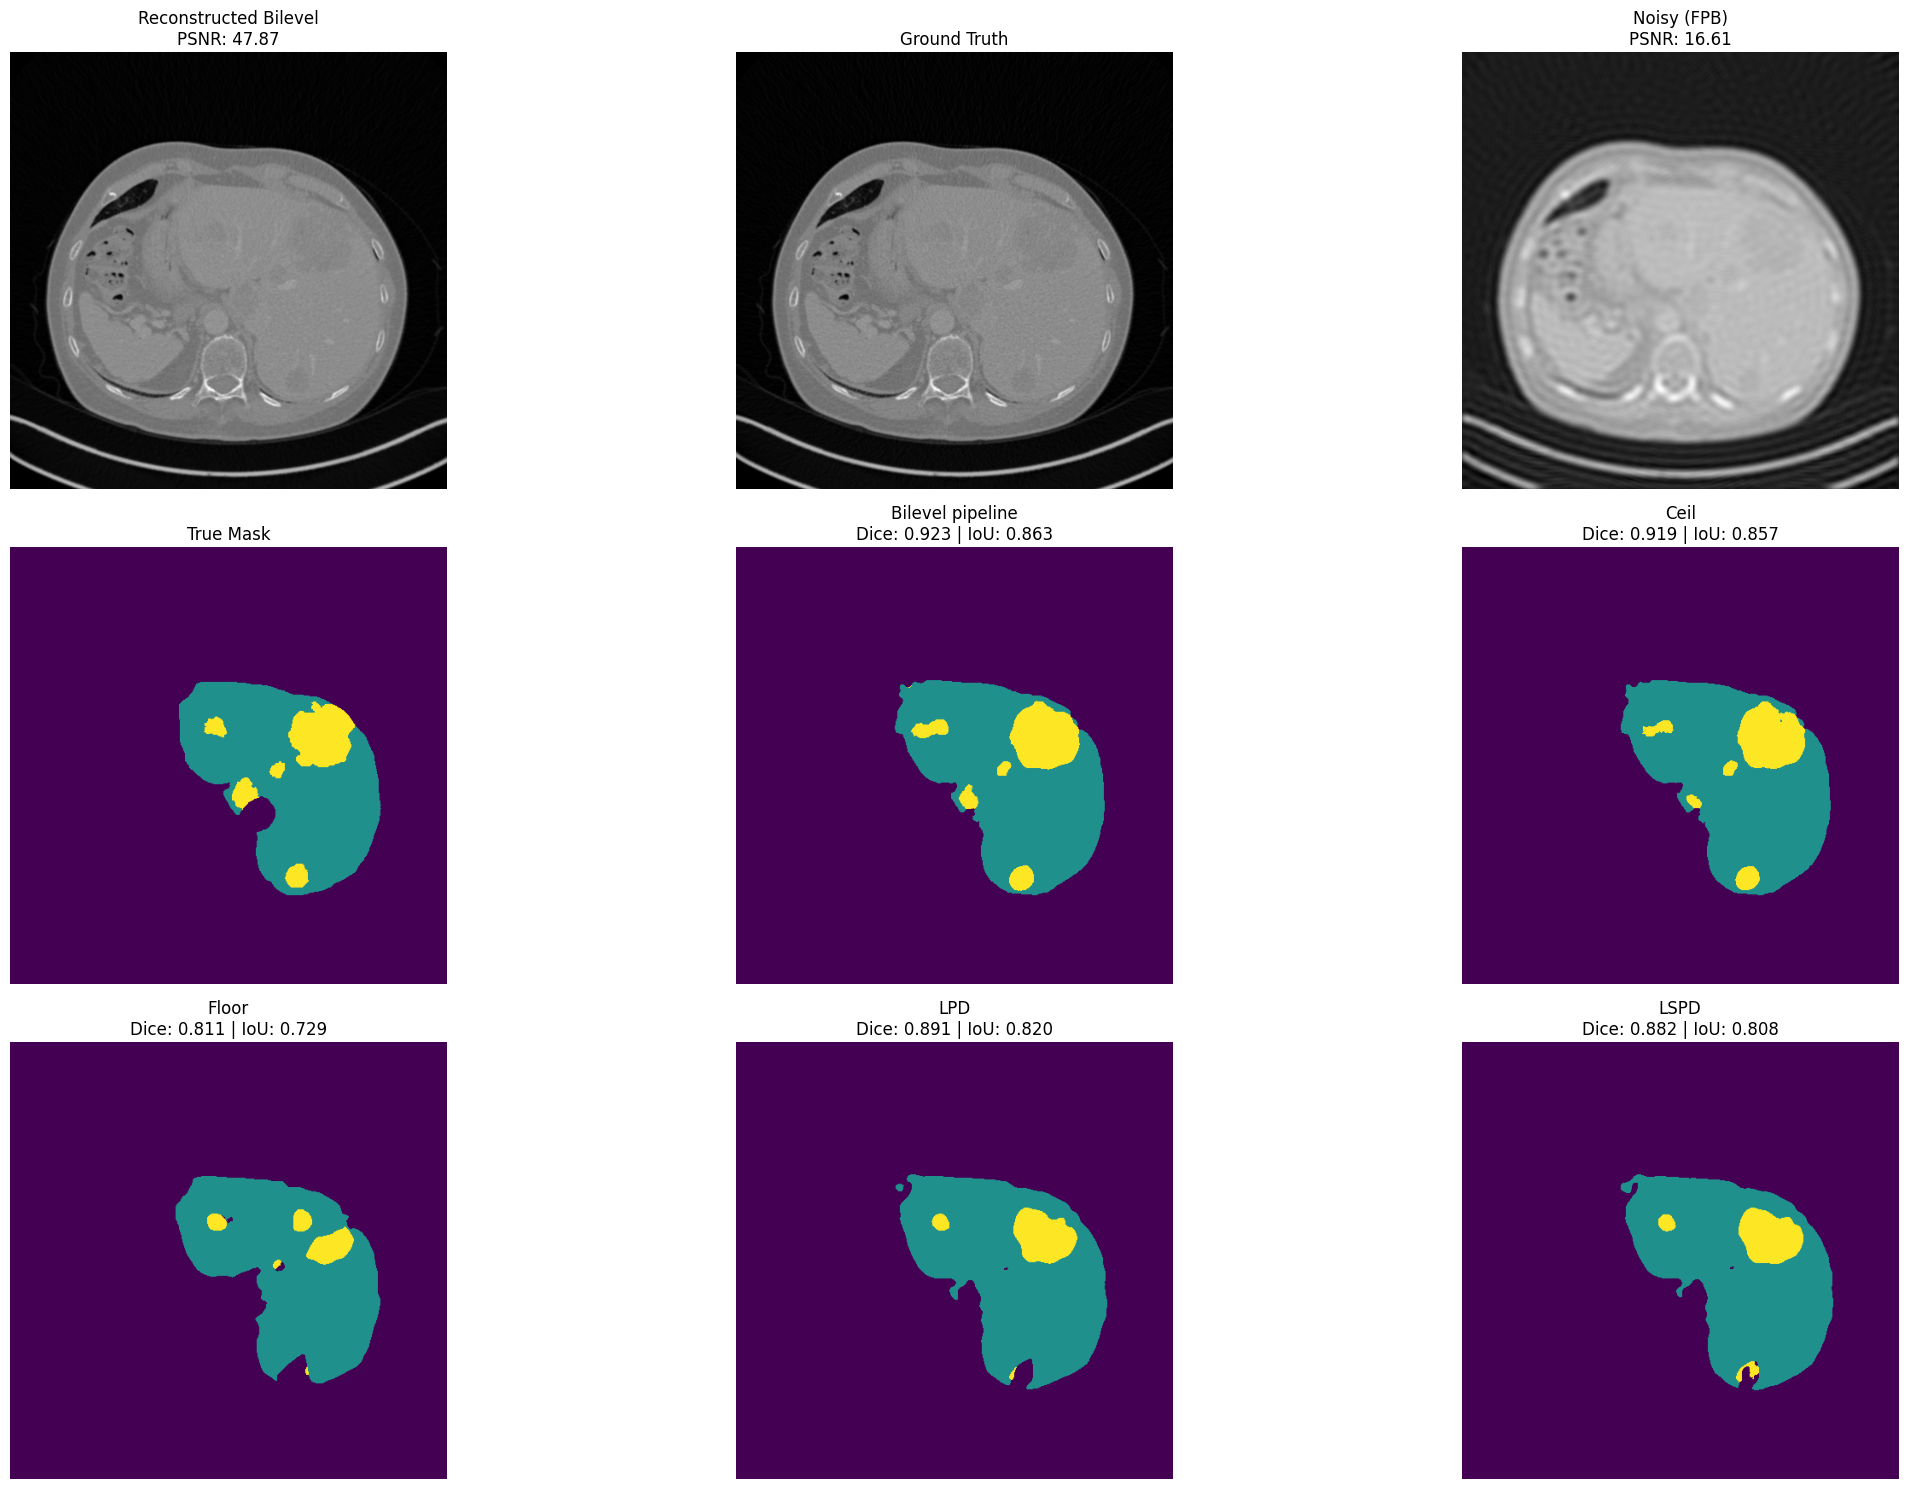

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from skimage.metrics import peak_signal_noise_ratio as compute_psnr

# Function to map class labels to RGB colors
def map_classes_to_colors(segmentation, num_classes):
    cmap = plt.get_cmap("viridis", num_classes)
    colored_segmentation = cmap(segmentation.numpy() / (num_classes - 1))
    return colored_segmentation[..., :3]

# Dice and IoU computation
def compute_dice_iou(pred, target, num_classes):
    dice_list, iou_list = [], []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        total = pred_cls.sum().item() + target_cls.sum().item()
        dice = 2 * intersection / total if total != 0 else 1.0
        iou = intersection / union if union != 0 else 1.0
        dice_list.append(dice)
        iou_list.append(iou)
    return np.mean(dice_list), np.mean(iou_list)

# Parameters
n_samples = 1
num_classes = 3
# random_indices = random.sample(range(len(saved_images)), n_samples)
# random_indices = list(np.arange(40,50,1))
random_indices = [47]

fig, axs = plt.subplots(n_samples * 3, 3, figsize=(24, 15 * n_samples))
axs = np.array(axs)
if axs.ndim == 1:
    axs = axs.reshape((3 * n_samples, 3))

for row, idx in enumerate(random_indices):
    reconstructed_image, ground_truth, noisy_image = saved_images[idx]
    true_mask, predicted_mask = saved_masks[idx]
    with torch.no_grad():
        pred = T_star(ground_truth.to(device))
        seg_probs = torch.softmax(pred, dim=1)
        clean_pred_mask = torch.argmax(seg_probs, dim=1)

        measurements = A(ground_truth.to(device)).to(device)
        x_recon = loaded_net_floor(y=measurements.to(device), x_init=noisy_image.to(device))
        seg_logits = loaded_segmentation_net_floor(x_recon.to(device))
        seg_probs = torch.softmax(seg_logits, dim=1)
        mask_floor = torch.argmax(seg_probs, dim=1)

        x_recon = loaded_net_LSPD(y=measurements.to(device), x_init=noisy_image.to(device), num_partitions=num_parts)
        seg_logits = loaded_segmentation_net_LSPD(x_recon.to(device))
        seg_probs = torch.softmax(seg_logits, dim=1)
        mask_LSPD = torch.argmax(seg_probs, dim=1)

        x_recon = loaded_net_LPD(y=measurements.to(device), x_init=noisy_image.to(device))
        seg_logits = loaded_segmentation_net_LPD(x_recon.to(device))
        seg_probs = torch.softmax(seg_logits, dim=1)
        mask_LPD = torch.argmax(seg_probs, dim=1)

    # Extract first sample from batch
    recons = reconstructed_image[0].permute(1, 2, 0).cpu().numpy()
    gt = ground_truth[0].permute(1, 2, 0).cpu().numpy()
    noisy = noisy_image[0].permute(1, 2, 0).cpu().numpy()
    true_mask = true_mask[0].cpu()
    pred_mask = predicted_mask[0].cpu()
    clean_pred_mask = clean_pred_mask[0].cpu()

    # Normalize and convert to [0, 255]
    recons_norm = ((recons - recons.min()) / (recons.max() - recons.min() + 1e-8)) * 255 if recons.max() > 0 else recons
    gt_norm = ((gt - gt.min()) / (gt.max() - gt.min() + 1e-8)) * 255 if gt.max() > 0 else gt
    noisy_norm = ((noisy - noisy.min()) / (noisy.max() - noisy.min() + 1e-8)) * 255 if noisy.max() > 0 else noisy

    # PSNR
    psnr_recons = compute_psnr(gt_norm, recons_norm, data_range=255)
    psnr_noisy = compute_psnr(gt_norm, noisy_norm, data_range=255)

    # Dice & IoU
    dice, iou = compute_dice_iou(pred_mask, true_mask, num_classes)
    dice1, iou1 = compute_dice_iou(clean_pred_mask, true_mask, num_classes)
    dice_floor, iou_floor = compute_dice_iou(mask_floor[0].cpu(), true_mask, num_classes)
    dice_LSPD, iou_LSPD = compute_dice_iou(mask_LSPD[0].cpu(), true_mask, num_classes)
    dice_LPD, iou_LPD = compute_dice_iou(mask_LPD[0].cpu(), true_mask, num_classes)
    
    # Color masks
    true_colored = map_classes_to_colors(true_mask, num_classes)
    pred_colored = map_classes_to_colors(pred_mask, num_classes)
    clean_pred_colored = map_classes_to_colors(clean_pred_mask, num_classes)
    floor_colored = map_classes_to_colors(mask_floor[0].cpu(), num_classes)
    LSPD_colored = map_classes_to_colors(mask_LSPD[0].cpu(), num_classes)
    LPD_colored = map_classes_to_colors(mask_LPD[0].cpu(), num_classes)

    
    axs[3 * row, 0].imshow(recons_norm, cmap="gray")
    axs[3 * row, 0].set_title(f"Reconstructed Bilevel\nPSNR: {psnr_recons:.2f}")
    axs[3 * row, 0].axis("off")

    axs[3 * row, 1].imshow(gt_norm, cmap="gray")
    axs[3 * row, 1].set_title("Ground Truth")
    axs[3 * row, 1].axis("off")

    axs[3 * row, 2].imshow(noisy_norm, cmap="gray")
    axs[3 * row, 2].set_title(f"Noisy (FPB)\nPSNR: {psnr_noisy:.2f}")
    axs[3 * row, 2].axis("off")

    # Second row: True Mask, Predicted Mask, Clean Predicted Mask
    axs[3 * row + 1, 0].imshow(true_colored)
    axs[3 * row + 1, 0].set_title("True Mask")
    axs[3 * row + 1, 0].axis("off")

    axs[3 * row + 1, 1].imshow(pred_colored)
    axs[3 * row + 1, 1].set_title(f"Bilevel pipeline\nDice: {dice:.3f} | IoU: {iou:.3f}")
    axs[3 * row + 1, 1].axis("off")

    axs[3 * row + 1, 2].imshow(clean_pred_colored)
    axs[3 * row + 1, 2].set_title(f"Ceil\nDice: {dice1:.3f} | IoU: {iou1:.3f}")
    axs[3 * row + 1, 2].axis("off")

    # Third row: Floor, LSPD, LPD masks
    axs[3 * row + 2, 0].imshow(floor_colored)
    axs[3 * row + 2, 0].set_title(f"Floor\nDice: {dice_floor:.3f} | IoU: {iou_floor:.3f}")
    axs[3 * row + 2, 0].axis("off")

    axs[3 * row + 2, 1].imshow(LPD_colored)
    axs[3 * row + 2, 1].set_title(f"LPD\nDice: {dice_LSPD:.3f} | IoU: {iou_LSPD:.3f}")
    axs[3 * row + 2, 1].axis("off")

    axs[3 * row + 2, 2].imshow(LSPD_colored)
    axs[3 * row + 2, 2].set_title(f"LSPD\nDice: {dice_LPD:.3f} | IoU: {iou_LPD:.3f}")
    axs[3 * row + 2, 2].axis("off")

plt.tight_layout()
plt.show()

In [140]:
1

1